# Objective

This work aims to use deep learning image recognition techniques to train a model to identify the most commercially common nine aircraft variant families and use the trained model to predict the variant family of new aircraft images.

The dataset consists of 3 subsets: 1800 training images, 900 validation images, and 900 testing images. Each subset consists of nine classes with balanced representation.

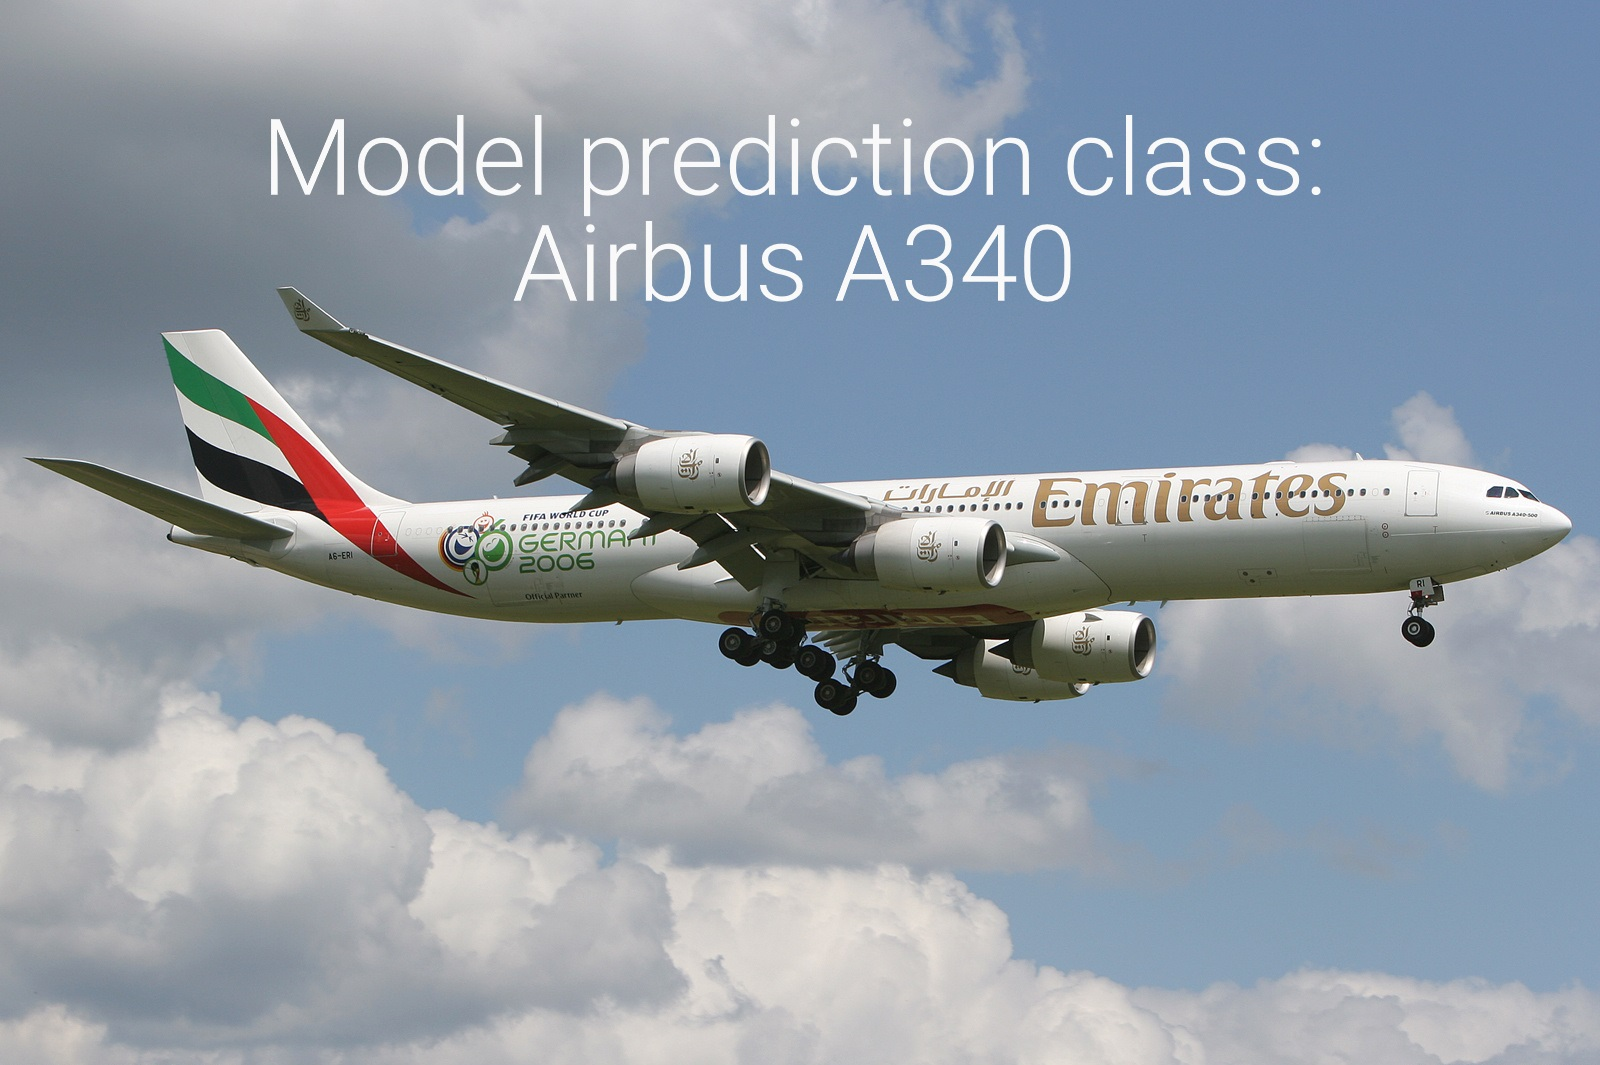

In [47]:
# Example
from PIL import Image
Image.open("prediction_example.jpeg")

# 0. Imports

In [1]:
#imports

#system
import os

#math
import numpy as np
import pandas as pd

#DL
from tensorflow.keras.utils import image_dataset_from_directory
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.layers import Flatten, Dense, Dropout, Conv2D, MaxPooling2D
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.applications.efficientnet_v2 import EfficientNetV2B1
from tensorflow.keras.applications.efficientnet_v2 import preprocess_input
from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.layers.experimental.preprocessing import RandomFlip
from tensorflow.keras.regularizers import l2


#visualization and reporting
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


# 1. Data Exploration

In [2]:
train_dataset_path = "aircraft_dataset/train"
validation_dataset_path = "aircraft_dataset/validation"
test_dataset_path = "aircraft_dataset/test"

In [3]:
# Exploring the training set

image_counts_train = []
for subdir, dirs, files in os.walk(train_dataset_path):
    file_count = len(files)
    if file_count > 0:
        image_counts_train.append((os.path.basename(subdir), file_count))
df_train = pd.DataFrame(image_counts_train, columns=['class', 'images'])
print(f'Total number of training images = {df_train.images.sum()}')
df_train

Total number of training images = 1800


,class,images
0,MD,200
1,DHC,200
2,E,200
3,DC,200
4,A340,200
5,747,200
6,767,200
7,737,200
8,CRJ,200


In [4]:
# Exploring the validation set

image_counts_val = []
for subdir, dirs, files in os.walk(validation_dataset_path):
    file_count = len(files)
    if file_count > 0:
        image_counts_val.append((os.path.basename(subdir), file_count))
df_val = pd.DataFrame(image_counts_val, columns=['class', 'images'])
print(f'Total number of validation images = {df_val.images.sum()}')
df_val

Total number of validation images = 900


,class,images
0,MD,100
1,DHC,100
2,E,100
3,DC,100
4,A340,100
5,747,100
6,767,100
7,737,100
8,CRJ,100


In [5]:
# Exploring the test set

image_counts_test = []
for subdir, dirs, files in os.walk(test_dataset_path):
    file_count = len(files)
    if file_count > 0:
        image_counts_test.append((os.path.basename(subdir), file_count))
df_test = pd.DataFrame(image_counts_test, columns=['class', 'images'])
print(f'Total number of testing images = {df_test.images.sum()}')
df_test

Total number of testing images = 900


,class,images
0,MD,100
1,DHC,100
2,E,100
3,DC,100
4,A340,100
5,747,100
6,767,100
7,737,100
8,CRJ,100


# 2. Preparing the training and valadation datasets

In [6]:
# Using image_dataset_from_directory function from Keras library

Xy_train = image_dataset_from_directory(
    directory= train_dataset_path,
    labels='inferred',
    label_mode='categorical',
    batch_size=32,
    image_size=(256, 256),
    shuffle=True)

Found 1800 files belonging to 9 classes.


In [7]:
Xy_val = image_dataset_from_directory(
    directory= validation_dataset_path,
    labels='inferred',
    label_mode='categorical',
    batch_size=32,
    image_size=(256, 256),
    shuffle=True)

Found 900 files belonging to 9 classes.


# 3. Preprocessing training and validation dataset

In [8]:
# Using preprocess_input function from EfficientNetV2B1 transfer learning model

Xy_train_preprocessed = Xy_train.map(lambda x, y: (preprocess_input(x), y))
Xy_val_preprocessed = Xy_val.map(lambda x, y: (preprocess_input(x), y))

# 4. Utilizing a transfer learning model and constructing the DL model

In [9]:
# Transfer learning

tl_model = EfficientNetV2B1(weights='imagenet', include_top=False, input_shape=(256, 256, 3))
tl_model.trainable = False

28456008/28456008 [==============================] - 0s 0us/step


In [10]:
# Combining transfer learning model with custom layers

model = Sequential([
    RandomFlip('horizontal'),
    tl_model,
    Conv2D(128, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.011)),
    MaxPooling2D((2, 2)),
    Conv2D(256, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.011)),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(256, activation='relu', kernel_regularizer=l2(0.01)),
    Dropout(0.5),
    Dense(128, activation='relu', kernel_regularizer=l2(0.01)),
    Dropout(0.5),
    Dense(9, activation='softmax')
])

# 5. Training the DL model

In [11]:
# Setting callback paramters

early_stopping = EarlyStopping(
    monitor='val_loss', 
    patience=4,           
    restore_best_weights=True)

lr = ReduceLROnPlateau(monitor="val_loss",
                       factor=0.1,
                       patience=2,
                       verbose=1,
                       min_lr=0)

mcp = ModelCheckpoint("{}.h5".format('saved_model'),
                      save_weights_only=False,
                      monitor='val_loss',
                      mode='auto',
                      verbose=0,
                      save_best_only=True)


In [12]:
opt = optimizers.Adam(learning_rate=1e-4)

model.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])


history = model.fit(
    Xy_train_preprocessed,
    epochs=100,  
    validation_data=Xy_val_preprocessed,
    verbose=0,
    callbacks=[early_stopping, lr, mcp]
)

2023-09-14 13:12:25.314413: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential/efficientnetv2-b1/block1b_drop/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer



Epoch 54: ReduceLROnPlateau reducing learning rate to 9.999999747378752e-06.

Epoch 82: ReduceLROnPlateau reducing learning rate to 9.999999747378752e-07.

Epoch 90: ReduceLROnPlateau reducing learning rate to 9.999999974752428e-08.

Epoch 92: ReduceLROnPlateau reducing learning rate to 1.0000000116860975e-08.


# 6. Validating the DL model

In [13]:
# Evaluate the model on the validation dataset
accuracy = model.evaluate(Xy_val_preprocessed, verbose=1)

29/29 [==============================] - 6s 168ms/step - loss: 1.2719 - accuracy: 0.9233


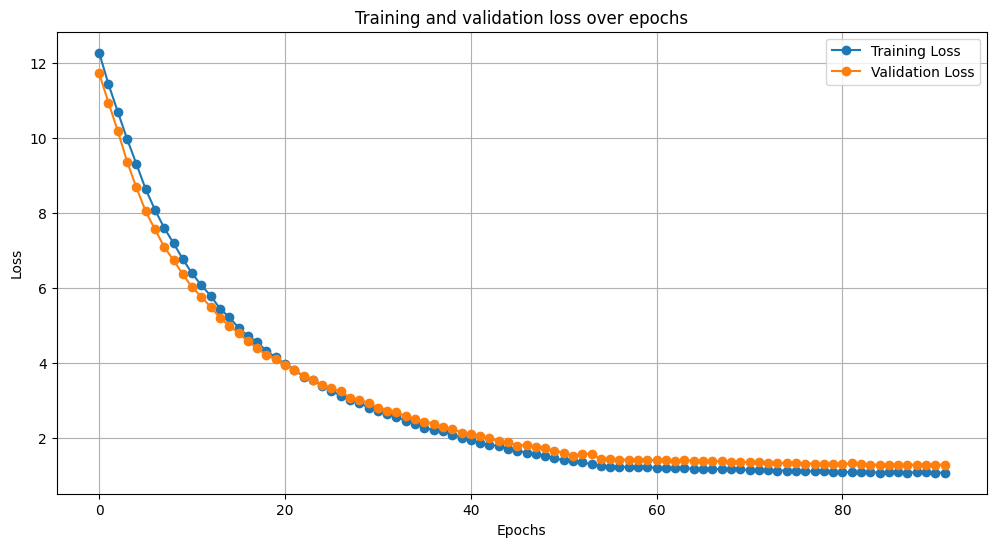

In [14]:
# Plotting loss curve

train_loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(12, 6))
plt.plot(train_loss, label='Training Loss', marker='o')
plt.plot(val_loss, label='Validation Loss', marker='o')
plt.title('Training and validation loss over epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

# 7. Testing the DL model

In [15]:
# Constructing the test dataset for evaluation with shuffling enabled similar to the training set

Xy_test = image_dataset_from_directory(
    directory= test_dataset_path,
    labels='inferred',
    label_mode='categorical',
    batch_size=32,
    image_size=(256, 256),
    shuffle=True)

Xy_test_preprocessed = Xy_test.map(lambda x, y: (preprocess_input(x), y))

Found 900 files belonging to 9 classes.


In [16]:
test_result = model.evaluate(Xy_test_preprocessed, verbose=1)

29/29 [==============================] - 10s 253ms/step - loss: 1.2714 - accuracy: 0.9244


# 8. Reporting

In [17]:
# Reconstructing the test set without schuffling to use it in writing the classification report

Xy_test_unshuffled = image_dataset_from_directory(
    directory= test_dataset_path,
    labels='inferred',
    label_mode='categorical',
    batch_size=32,
    image_size=(256, 256),
    shuffle=False)

Xy_test_preproc_unshuffled = Xy_test_unshuffled.map(lambda x, y: (preprocess_input(x), y))

Found 900 files belonging to 9 classes.


In [18]:
# Prediction

y_pred_encoded = model.predict(Xy_test_preproc_unshuffled, batch_size=32)
y_pred_class_num = np.argmax(y_pred_encoded, axis=1)


29/29 [==============================] - 9s 219ms/step


In [19]:
# Creating y_true

Xy_test_preprocessed_unbatched = Xy_test_unshuffled.unbatch()
y_true_encoded = np.array(list(Xy_test_preprocessed_unbatched.map(lambda x, y:  y)))
y_true= np.argmax(y_true_encoded, axis=1)

In [20]:
# Writing classification report

classes = ['737', '747','767','A340','CRJ','DC','DHC','E','MD']
report = classification_report(y_true, y_pred_class_num, target_names=classes)
print(report)

              precision    recall  f1-score   support

         737       0.90      0.90      0.90       100
         747       0.93      0.84      0.88       100
         767       0.90      0.90      0.90       100
        A340       0.88      0.92      0.90       100
         CRJ       0.95      0.96      0.96       100
          DC       0.91      0.99      0.95       100
         DHC       0.93      0.97      0.95       100
           E       0.97      0.95      0.96       100
          MD       0.96      0.89      0.92       100

    accuracy                           0.92       900
   macro avg       0.93      0.92      0.92       900
weighted avg       0.93      0.92      0.92       900



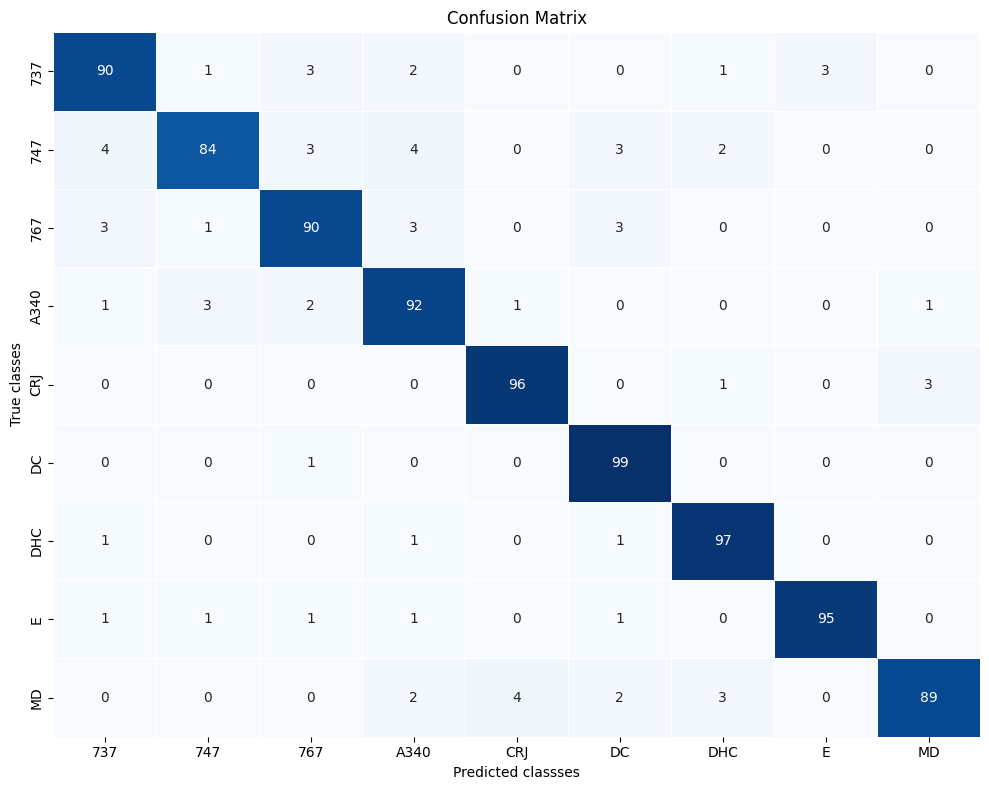

In [21]:
# Constructing confusion matrix

cm = confusion_matrix(y_true=y_true, y_pred=y_pred_class_num)
df_cm = pd.DataFrame(cm, columns=classes, index=classes)

fig, ax = plt.subplots(figsize=(10, 8))

sns.heatmap(df_cm, annot=True, cmap='Blues', fmt='d', linewidths=0.5, cbar=False, ax=ax)

ax.set_xlabel('Predicted classses')
ax.set_ylabel('True classes')
ax.set_title('Confusion Matrix')
plt.tight_layout()
plt.show()

# Final notes

- The loss curve exhibits no signs of overfitting. The model is able to generalize well on new images
- The model shows good performance with 92% accuracy on both validation and test sets
- As seen from the confusion matrix, the accuracy of predicting individual classes varies in the range of 84-97%. This can also be considered as the probability of true positive predictions per class, since the test dataset has 100 datapoint per class.

